In [2]:
%matplotlib inline
morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'
import h5py

from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())
sdss = sdss[sdss['z'] < 0.07]

['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


In [3]:
import os
snapnum = 247
dirname = "/Volumes/simulation_data_2018/protoDC2_v4p11"
mpeak = np.load(os.path.join(dirname, 'mpeak_{0}_v4p11.npy'.format(snapnum)))
mstar = np.load(os.path.join(dirname, 'obs_sm_{0}_v4p11.npy'.format(snapnum)))
magr = np.load(os.path.join(dirname, 'magr_{0}_v4p11.npy'.format(snapnum)))


## Extend $M_{\rm peak}$ beyond resolution limit

In [4]:
from cosmodc2.synthetic_subhalos import model_extended_mpeak
corrected_mpeak, mpeak_extension = model_extended_mpeak(mpeak, 9.5)
new_mpeak = np.concatenate((corrected_mpeak, mpeak_extension))

## Remap $M_{\star}$ based on new subhalo masses

In [ ]:
low, high = 11, 11.5
mid = 0.5*(low + high)
mask = (mpeak >= 10**low) & (mpeak < 10**high)
c1, c0 = np.polyfit(
    np.random.normal(loc=np.log10(mpeak[mask])-mid, scale=0.002), np.log10(mstar[mask]), deg=1)

low_mass_slope_boost = 0.25
new_median_logsm = c0 + (c1-low_mass_slope_boost)*(np.log10(new_mpeak)-mid)
new_mstar_lowmass = 10**np.random.normal(loc=new_median_logsm, scale=0.4)


logmtrans_low, logmtrans_high = 10.8, 11.2
reassign_mstar_prob = np.interp(np.log10(new_mpeak), [logmtrans_low, logmtrans_high], [1, 0])
reassign_mstar_mask = np.random.rand(len(new_mpeak)) < reassign_mstar_prob
new_mstar = np.zeros_like(new_mpeak)
new_mstar[:len(mpeak)] = mstar
new_mstar[reassign_mstar_mask] = new_mstar_lowmass[reassign_mstar_mask]


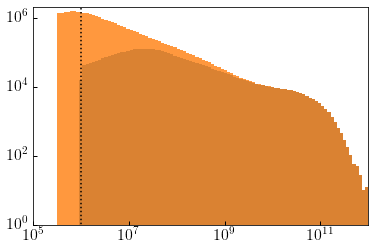

In [6]:

sm_bins = np.logspace(5.5, 12, 100)

fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.hist(mstar, bins=sm_bins, alpha=0.8, color=mblue)
__=ax.hist(new_mstar, bins=sm_bins, alpha=0.8, color=morange)
__=ax.plot(np.zeros(100) + 10**6, np.logspace(-2, 10, 100), ':', color='k')
xlim = ax.set_xlim(1e5, 1e12)
ylim = ax.set_ylim(1, 2e6)


## Remap $M_{\rm r}$ based on new $M_{\star}$

In [15]:
from cosmodc2.sdss_colors.sigmoid_magr_model import magr_monte_carlo

new_magr_z0p0 = magr_monte_carlo(new_mstar, -np.ones_like(new_mstar), np.zeros_like(new_mstar) + 0)
new_magr_z0p5 = magr_monte_carlo(new_mstar, -np.ones_like(new_mstar), np.zeros_like(new_mstar) + 0.5)
new_magr_z0p75 = magr_monte_carlo(new_mstar, -np.ones_like(new_mstar), np.zeros_like(new_mstar) + 0.75)
new_magr_z1p0 = magr_monte_carlo(new_mstar, -np.ones_like(new_mstar), np.zeros_like(new_mstar) + 1)

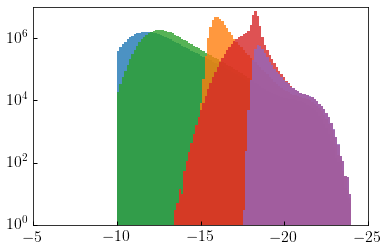

In [20]:
magr_bins = np.linspace(-24, -10, 100)

fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')
__=ax.hist(new_magr_z0p0, bins=magr_bins, alpha=0.8, color=mblue)
__=ax.hist(new_magr_z0p5, bins=magr_bins, alpha=0.8, color=mgreen)
__=ax.hist(new_magr_z0p75, bins=magr_bins, alpha=0.8, color=morange)
__=ax.hist(new_magr_z1p0, bins=magr_bins, alpha=0.8, color=mred)
__=ax.hist(magr, bins=magr_bins, alpha=0.8, color=mpurple)

xlim = ax.set_xlim(-5, -25)
ylim = ax.set_ylim(1, 1e7)

xlabel = ax.set_xlabel(r'${\rm M_r}$')

In [24]:
len(new_magr)/float(len(magr))

9.935691854137334

In [ ]:
from scipy.stats import binned_statistic
logmpeak_bins = np.linspace(10, 14.5, 30)
logmpeak_mids = 0.5*(logmpeak_bins[:-1] + logmpeak_bins[1:])
median_logsm, __, __ = binned_statistic(np.log10(mpeak), np.log10(mstar), bins=logmpeak_bins, statistic='median')



mask = (mpeak > 10**11) & (mpeak < 10**11.5)
mask2 = (mpeak > 10**11) & (mpeak < 10**12)
x = np.random.normal(loc=np.log10(mpeak[mask]), scale=0.002)
y = np.log10(mstar[mask])
c1, c0 = np.polyfit(x, y, deg=1)
x2 = np.random.normal(loc=np.log10(mpeak[mask2]), scale=0.002)
y2 = np.log10(mstar[mask2])
b1, b0 = np.polyfit(x2, y2, deg=1)

fig, ax = plt.subplots(1, 1)
__=ax.scatter(np.log10(mpeak)[::300], np.log10(mstar)[::300], s=0.1)
xarr = np.linspace(10, 12, 100)
__=ax.plot(xarr, c0 + c1*xarr, color=mpurple)
__=ax.plot(xarr, b0 + b1*xarr, color=mgreen)

__=ax.plot(logmpeak_mids, median_logsm, color=mred)
xlim = ax.set_xlim(10, 12)

In [ ]:
low, high = 11, 11.5
mid = 0.5*(low + high)
mask = (mpeak >= 10**low) & (mpeak < 10**high)
c1, c0 = np.polyfit(
    np.random.normal(loc=np.log10(mpeak[mask])-mid, scale=0.002), np.log10(mstar[mask]), deg=1)

new_median_logsm = c0 + c1*(np.log10(mpeak)-mid)
new_mstar_lowmass = 10**np.random.normal(loc=new_median_logsm, scale=0.2)

fig, ax = plt.subplots(1, 1)

_x = np.random.normal(loc=np.log10(mpeak), scale=0.03)
__=ax.scatter(_x[::300], np.log10(mstar)[::300], s=0.1, color='gray')
xarr = np.linspace(9.75, 12, 100)

__=ax.plot(xarr, c0 + c1*(xarr-mid), color=mred)
__=ax.plot(xarr, c0 + (c1 - 0.5)*(xarr-mid), color=morange)

# __=ax.plot(logmpeak_mids, median_logsm, color=mred)

xlim = ax.set_xlim(9.75, 12)
ylim = ax.set_ylim(5, 11)


In [ ]:
low, high = 11, 11.5
mid = 0.5*(low + high)
mask = (mpeak >= 10**low) & (mpeak < 10**high)
c1, c0 = np.polyfit(
    np.random.normal(loc=np.log10(mpeak[mask])-mid, scale=0.002), np.log10(mstar[mask]), deg=1)

low_mass_slope_boost = 0.5
new_median_logsm = c0 + (c1-low_mass_slope_boost)*(np.log10(mpeak)-mid)
new_mstar_lowmass = 10**np.random.normal(loc=new_median_logsm, scale=0.2)


logmtrans_low, logmtrans_high = 10.8, 11.2
reassign_mstar_prob = np.interp(np.log10(mpeak), [logmtrans_low, logmtrans_high], [1, 0])
reassign_mstar_mask = np.random.rand(len(mpeak)) < reassign_mstar_prob
new_mstar = np.copy(mstar)
new_mstar[reassign_mstar_mask] = new_mstar_lowmass[reassign_mstar_mask]

from scipy.stats import binned_statistic
logmpeak_bins = np.linspace(10, 14.5, 30)
logmpeak_mids = 0.5*(logmpeak_bins[:-1] + logmpeak_bins[1:])
median_logsm, __, __ = binned_statistic(
    np.log10(mpeak), np.log10(mstar), bins=logmpeak_bins, statistic='median')
median_new_logsm, __, __ = binned_statistic(
    np.log10(mpeak), np.log10(new_mstar), bins=logmpeak_bins, statistic='median')


fig, ax = plt.subplots(1, 1)

_x = np.random.normal(loc=np.log10(mpeak), scale=0.03)
__=ax.scatter(_x[::300], np.log10(mstar)[::300], s=0.1, color='gray')
__=ax.scatter(_x[::300], np.log10(new_mstar)[::300], s=0.1, color=mred)

__=ax.plot(logmpeak_mids, median_logsm, color='k')
__=ax.plot(logmpeak_mids, median_new_logsm, '--', color='k')

xlim = ax.set_xlim(9.75, 13)
xlabel = ax.set_xlabel(r'${\log M_{\rm peak}}$')
ylabel = ax.set_ylabel(r'${\log M_{\star}}$')



In [ ]:
from cosmodc2.synthetic_subhalos import model_extended_mpeak
corrected_mpeak, mpeak_extension = model_extended_mpeak(mpeak, 9.75)

from cosmodc2.stellar_mass_remapping import remap_stellar_mass_in_snapshot
new_real_mstar = remap_stellar_mass_in_snapshot(1., corrected_mpeak, mstar)

mask = (mpeak > 10**11) & (mpeak < 10**11.25)
x = np.log10(mpeak[mask]) + + np.random.normal(loc=0, scale=0.0025, size=np.count_nonzero(mask))
y = np.log10(mstar[mask]) 
c1, c0 = np.polyfit(x, y, deg=1)

new_mstar_extension = 10**np.random.normal(loc=(c0 + c1*np.log10(mpeak_extension)), scale=0.1)
new_mstar = np.concatenate((new_real_mstar, new_mstar_extension))